<a href="https://colab.research.google.com/github/AbdulrhmnGhanem/bdd100k-trajectories/blob/main/sub_trajectories.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Reproducible-ish dependencies
!pip install \
    pandas==1.3.5 \
    requests==2.23.0 \
    geopy==1.17.0 \
    imageio==2.4.1 \
    Pillow==7.1.2

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
from getpass import getpass
API_KEY = getpass('Enter the google maps API key: ')

Enter the google maps API key: ··········


## Get pickled data

In [3]:
import pickle


with open('/content/drive/MyDrive/all_gps_data.pkl', 'rb') as f:
  all_gps_data = pickle.load(f)

training_data = [trajectory 
                 for trajectory in all_gps_data["train"]
                 if len(trajectory[1]) != 0]

# Get the distance between the first and last points in a trajectory

In [4]:
import geopy.distance
import pandas as pd


pd.set_option('display.float_format', lambda x: '%.3f' % x)

first_and_last_points = [(
                  (trajectory[1][0]["latitude"], trajectory[1][0]["longitude"]),   # # The coordinates of the first point in the trajectory.
                  (trajectory[1][-1]["latitude"], trajectory[1][-1]["longitude"])  # The coordinates of the last point in the trajectory.
                  ) 
                  for trajectory in training_data]    
distance_between_frist_and_last_point_in_each_trajectory = [
                round(geopy.distance.vincenty(x, y).meters)
                for (x, y) in first_and_last_points]

df = pd.DataFrame({"Distance between first andf last point in trajectories (m)": distance_between_frist_and_last_point_in_each_trajectory})
less_than_500_m = df[df['Distance between first andf last point in trajectories (m)'] <= 500]

less_than_500_m.describe()

,Distance between first andf last point in trajectories (m)
count,45854.000
mean,220.972
std,111.051
min,0.000
25%,142.000
50%,215.000
75%,292.000
max,500.000


# What disatance google image can cover at `zoom=20`

In [5]:
import io

import numpy as np
import PIL
import imageio
import requests



def mark_trajectory(points, *,zoom, scale, size):
  base_url = "https://maps.googleapis.com/maps/api/staticmap"
  key=API_KEY
  markers = '|'.join(f'{point["latitude"]}, {point["longitude"]}' for point in points)

  img_url = f"{base_url}?key={key}&zoom={zoom}&scale={scale}" \
                f"&size={size}&maptype=satellite&format=png" \
                f"&visual_refresh=true&markers={markers}"
  return PIL.Image.open(
      io.BytesIO(requests.get(img_url).content)).convert('RGB')


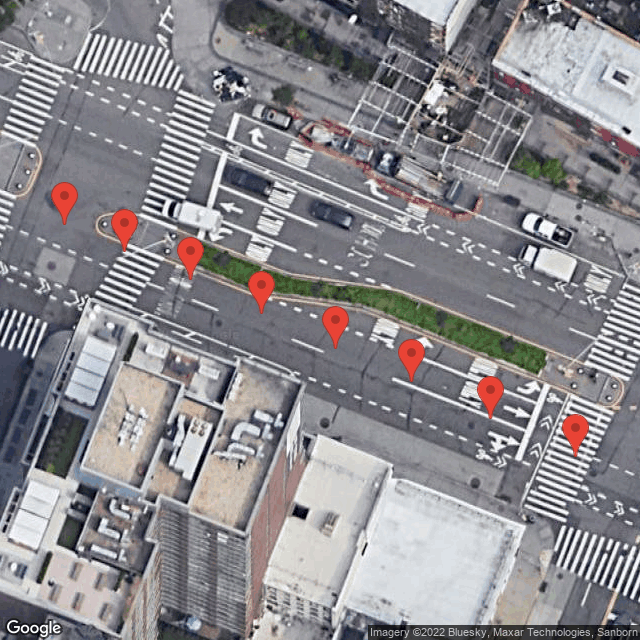

In [9]:
mark_trajectory(training_data[6][1][1:9], zoom=20, scale=1, size="800x800")



- At `zoom = 20` and `size = "800x800"`, `training_data[6]` **8** points are covered.
  ```python
  mark_trajectory(training_data[6][1][1:9], zoom=20, scale=1, size="800x800")
  ```
    ![](https://drive.google.com/uc?export=view&id=1bhKyVjNjublq5TPRlEcJPWINNBG2fjcB)



In [10]:
first_point = training_data[6][1][1]
last_point = training_data[6][1][8]
geopy.distance.vincenty(
    (first_point["latitude"], first_point["longitude"]),
    (last_point["latitude"], last_point["longitude"])
    ).meters

63.5875785837943

## A **wishful** approach for generating the trajectories

* Divide each trajectory into $50m$ sub trajectory.
* This means getting rid of trajectories with a total distance less than $50m$
  * To avoid removing trajectories starting and ending at close points, calculate the total trajectory distance; calculate the distance between the adjacent points, then aggregate.
  * Take care of the noise; if a single GPS location off, it will skew the total distance.
  * Compare the statistical summary of the *total distance* vs the *distance between the first and the last points*, the results should be close.

### Division
* Assuming we managed to divide the trajectories into $50m$ sub-trajectories.
* We have the speed at each point, and we can assume constant speed between adjacent points of the average speed at these point $v_n = {v_{n} + v_{n+1} \over 2}$.
* The time between adjacent points is $1s$.
* If we are going to sample the sub-trajectory at $10m$ then we will divide the sub-trajectory into $5$ intervals.
* To get the time of corresponding frame for the $nth$ point we can use this formula $t_n={d \times n \over v_n}={10n \over v_n}$.
* Then pass the list of $t_n$s to `ffmpeg` to extract the frames. 
